<a href="https://colab.research.google.com/github/gal-dmitry/HSE_RecSys/blob/master/HW_02/HW_02_PIPELINE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost==1.0.3
!pip install gensim==4.1.0
!pip install --upgrade numpy

     |████████████████████████████████| 76.3 MB 54 kB/s 
     |████████████████████████████████| 24.0 MB 1.6 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 15.7 MB 28.3 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.4 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [1]:
!pip install shap

     |████████████████████████████████| 564 kB 35.1 MB/s 


In [2]:
!wget https://voudy-data.s3.eu-north-1.amazonaws.com/wsdm_data.tar.gz
!tar -xf /content/wsdm_data.tar.gz

--2021-12-12 12:27:58--  https://voudy-data.s3.eu-north-1.amazonaws.com/wsdm_data.tar.gz
Resolving voudy-data.s3.eu-north-1.amazonaws.com (voudy-data.s3.eu-north-1.amazonaws.com)... 52.95.171.56
Connecting to voudy-data.s3.eu-north-1.amazonaws.com (voudy-data.s3.eu-north-1.amazonaws.com)|52.95.171.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 613394184 (585M) [application/x-gzip]
Saving to: ‘wsdm_data.tar.gz’

wsdm_data.tar.gz    100%[===================>] 584.98M  28.2MB/s    in 22s     

2021-12-12 12:28:21 (26.5 MB/s) - ‘wsdm_data.tar.gz’ saved [613394184/613394184]



In [3]:
from google.colab import files
files.upload()
files.upload()

Saving wikipedia-iso-country-codes.csv to wikipedia-iso-country-codes.csv


Saving data_processing.py to data_processing.py
Saving train_utils.py to train_utils.py


{'data_processing.py': b'import csv\nimport numpy as np\nimport pandas as pd\nfrom tqdm import tqdm\n\n\n"""\nDATA LOADING\n"""        \ndef load_members(path):\n    return pd.read_csv(path, \n                       dtype={\n                        "msno": "category",\n                        "city": "category",\n                        "bd": np.uint8,\n                        "gender": "category",\n                        "registered_via": "category"\n                       }, \n                       parse_dates=["registration_init_time", "expiration_date"])\n\n\n\ndef load_song_extra_info(path):\n    return pd.read_csv(path, \n                       dtype={\n                        "song_id": "category",\n                        "name": "category"\n                       })\n\n\ndef load_songs(path):\n    return pd.read_csv(path, \n                       dtype={\n                        "song_id": "category",\n                        "song_length": np.int32,\n                       

In [4]:
import pandas as pd
import numpy as np

SEED = 42

In [5]:
from train_utils import *
from data_processing import get_preprocessed_dataset

#### Dataset

Подготовка датасета. Детальное описание: [`HW_02_DATA_PREPROCESSING.ipynb`](https://github.com/gal-dmitry/HSE_RecSys/blob/master/HW_02/HW_02_DATA_PREPROCESSING.ipynb)

In [6]:
%%time
dataset = get_preprocessed_dataset(csv_folder_path=".")

process members...
process songs...
process songs extra info...
merge songs...
process train...


100%|██████████| 3/3 [00:00<00:00, 53.47it/s]


merge train...
get final dataset...



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CPU times: user 1min 41s, sys: 3.39 s, total: 1min 45s
Wall time: 1min 44s


In [ ]:
### check reproducibility

# restored = pd.read_pickle("full_extended_train_df.pkl")
# assert restored.equals(dataset)
# del restored

In [7]:
TRAIN_DATASET = TrainDataset(dataset[:1_200])
# TRAIN_DATASET = TrainDataset(restored)

TRAIN_DATASET._df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,gender,registered_via,age_group,registration_init_year,expiration_date_year,song_length,genre_ids,artist_name,composer,lyricist,language,genre_ids_count,artist_name_count,composer_count,lyricist_count,isrc_country,isrc_year
3743055,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,DZanD98cLDbuPBiXONSwLFSw8BfI69ErQS23vYJ9UU4=,my library,Local playlist more,local-library,1,13,male,9,normal,2006,2017,224235,465,南拳媽媽,周杰倫,宋健彰,3.0,1,1,1,1,"Taiwan, Province of China",2008
2028065,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,E6Fm873UEDPv0LATidt2gKwBZZHww2Q04nxTg15N9iE=,my library,Local playlist more,local-library,1,13,male,9,normal,2006,2017,193410,465,張靚穎 (Jane Zhang),張靚穎,沈松,3.0,1,1,1,1,-1,-1
785721,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,0TZ4BKn9YES2upK9ZgKgsAUtUClVKHnct79pnA/iPiQ=,my library,Local playlist more,local-library,1,13,male,9,normal,2006,2017,187199,2022,Linkin Park,FILL_NAN,FILL_NAN,52.0,1,1,0,0,United States,2003
785720,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,m2YSjnhR3nzx/2WccNYpGWywohyd8fT0xR+skQC9/JQ=,my library,Local playlist more,local-library,1,13,male,9,normal,2006,2017,205635,359,Linkin Park,FILL_NAN,FILL_NAN,52.0,1,1,0,0,United States,2007
2973176,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,cXpk2ZXiSgkwGo8iGbswBc0lzucL9AH+j/2khmnmOLI=,my library,Local playlist more,local-playlist,0,13,male,9,normal,2006,2017,262687,2022,Starset,FILL_NAN,FILL_NAN,52.0,1,1,0,0,United States,2014


#### CatBoost

In [10]:
%%time
catboost_model = CatBoostModel(loss_function="YetiRank", 
                                 iterations=150, 
                                 task_type="CPU", 
                                 random_state=SEED)

catboost_auc_per_query = get_metric(catboost_model, TRAIN_DATASET, n_splits=5)

--- Split: 1/5 ---
Groupwise loss function. OneHotMaxSize set to 10
0:	total: 53.8ms	remaining: 8.02s
1:	total: 59.6ms	remaining: 4.41s
2:	total: 64.7ms	remaining: 3.17s
3:	total: 69.8ms	remaining: 2.55s
4:	total: 74.7ms	remaining: 2.17s
5:	total: 80.2ms	remaining: 1.93s
6:	total: 85ms	remaining: 1.74s
7:	total: 90.9ms	remaining: 1.61s
8:	total: 95.8ms	remaining: 1.5s
9:	total: 101ms	remaining: 1.41s
10:	total: 106ms	remaining: 1.33s
11:	total: 111ms	remaining: 1.27s
12:	total: 116ms	remaining: 1.22s
13:	total: 121ms	remaining: 1.17s
14:	total: 125ms	remaining: 1.13s
15:	total: 130ms	remaining: 1.09s
16:	total: 135ms	remaining: 1.06s
17:	total: 140ms	remaining: 1.03s
18:	total: 145ms	remaining: 1s
19:	total: 152ms	remaining: 989ms
20:	total: 157ms	remaining: 967ms
21:	total: 163ms	remaining: 945ms
22:	total: 168ms	remaining: 925ms
23:	total: 173ms	remaining: 906ms
24:	total: 178ms	remaining: 888ms
25:	total: 183ms	remaining: 871ms
26:	total: 188ms	remaining: 855ms
27:	total: 193ms	rema

In [11]:
catboost_auc_per_query

,AUC_per_query
split: 1,0.47777
split: 2,0.589155
split: 3,0.707739
split: 4,0.714433
split: 5,0.694981
avg,0.636815


#### Embeddings

In [8]:
%%time
embedding_model = EmbeddingModel(embedding_dim=100, 
                                 random_state=SEED, 
                                 min_count=1)
                                #  min_count=5)

embedding_auc_per_query = get_metric(embedding_model, TRAIN_DATASET, n_splits=5)

--- Split: 1/5 ---
Fit items...


Fit users: 100%|██████████| 30755/30755 [00:00<00:00, 137813.69it/s]


--- Split: 2/5 ---
Fit items...


Fit users: 100%|██████████| 30755/30755 [00:00<00:00, 132986.34it/s]


--- Split: 3/5 ---
Fit items...


Fit users: 100%|██████████| 30755/30755 [00:00<00:00, 130609.37it/s]


--- Split: 4/5 ---
Fit items...


Fit users: 100%|██████████| 30755/30755 [00:00<00:00, 127686.27it/s]


--- Split: 5/5 ---
Fit items...


Fit users: 100%|██████████| 30755/30755 [00:00<00:00, 153809.43it/s]

CPU times: user 52.4 s, sys: 3.01 s, total: 55.4 s
Wall time: 50.1 s


In [9]:
embedding_auc_per_query

,AUC_per_query
split: 1,0.5
split: 2,0.5
split: 3,0.5
split: 4,0.5
split: 5,0.5
avg,0.5


#### Embeddings + CatBoost

In [13]:
%%time
stack_model = StackModel(loss_function="YetiRank", 
                         iterations=150, 
                         task_type="CPU", 
                         random_state=SEED,
                         embedding_dim=100,
                         min_count=1)
                        #  min_count=5)

stack_scores = get_metric(stack_model, TRAIN_DATASET, n_splits=5)

--- Split: 1/5 ---
Fit items...


Fit users: 100%|██████████| 30755/30755 [00:00<00:00, 125771.17it/s]

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Groupwise loss function. OneHotMaxSize set to 10
0:	total: 5.79ms	remaining: 863ms
1:	total: 11.7ms	remaining: 862ms
2:	total: 17ms	remaining: 833ms
3:	total: 22.3ms	remaining: 814ms
4:	total: 27.6ms	remaining: 801ms
5:	total: 33ms	remaining: 792ms
6:	total: 38.3ms	remaining: 783ms
7:	total: 43.7ms	remaining: 776ms
8:	total: 49ms	remaining: 767ms
9:	total: 54.3ms	remaining: 760ms
10:	total: 59.9ms	remaining: 757ms
11:	total: 65.2ms	remaining: 750ms
12:	total: 70.7ms	remaining: 745ms
13:	total: 76.2ms	remaining: 740ms
14:	total: 81.6ms	remaining: 734ms
15:	total: 87ms	remaining: 729ms
16:	total: 92.6ms	remaining: 725ms
17:	total: 98.1ms	remaining: 719ms
18:	total: 104ms	remaining: 719ms
19:	total: 110ms	remaining: 715ms
20:	total: 116ms	remaining: 711ms
21:	total: 121ms	remaining: 706ms
22:	total: 127ms	remaining: 699ms
23:	total: 132ms	remaining: 693ms
24:	total: 137ms	remaining: 686ms
25:	total: 143ms	remaining: 680ms
26:	total: 148ms	remaining: 674ms
27:	total: 153ms	remaining: 667ms

Fit users: 100%|██████████| 30755/30755 [00:00<00:00, 127428.32it/s]

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Groupwise loss function. OneHotMaxSize set to 10
0:	total: 11ms	remaining: 1.64s
1:	total: 21.3ms	remaining: 1.57s
2:	total: 31.1ms	remaining: 1.52s
3:	total: 41ms	remaining: 1.5s
4:	total: 51ms	remaining: 1.48s
5:	total: 64.6ms	remaining: 1.55s
6:	total: 80ms	remaining: 1.63s
7:	total: 90.1ms	remaining: 1.6s
8:	total: 100ms	remaining: 1.57s
9:	total: 110ms	remaining: 1.54s
10:	total: 120ms	remaining: 1.51s
11:	total: 130ms	remaining: 1.49s
12:	total: 140ms	remaining: 1.47s
13:	total: 150ms	remaining: 1.46s
14:	total: 161ms	remaining: 1.45s
15:	total: 171ms	remaining: 1.44s
16:	total: 181ms	remaining: 1.42s
17:	total: 191ms	remaining: 1.4s
18:	total: 208ms	remaining: 1.44s
19:	total: 218ms	remaining: 1.42s
20:	total: 228ms	remaining: 1.4s
21:	total: 239ms	remaining: 1.39s
22:	total: 248ms	remaining: 1.37s
23:	total: 258ms	remaining: 1.35s
24:	total: 268ms	remaining: 1.34s
25:	total: 277ms	remaining: 1.32s
26:	total: 287ms	remaining: 1.3s
27:	total: 296ms	remaining: 1.29s
28:	total: 306

Fit users: 100%|██████████| 30755/30755 [00:00<00:00, 133535.49it/s]

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Groupwise loss function. OneHotMaxSize set to 10
0:	total: 10.7ms	remaining: 1.59s
1:	total: 20.8ms	remaining: 1.54s
2:	total: 30.7ms	remaining: 1.5s
3:	total: 40.7ms	remaining: 1.48s
4:	total: 50.8ms	remaining: 1.47s
5:	total: 60.5ms	remaining: 1.45s
6:	total: 70.4ms	remaining: 1.44s
7:	total: 80.3ms	remaining: 1.42s
8:	total: 89.9ms	remaining: 1.41s
9:	total: 99.8ms	remaining: 1.4s
10:	total: 110ms	remaining: 1.38s
11:	total: 120ms	remaining: 1.37s
12:	total: 129ms	remaining: 1.36s
13:	total: 139ms	remaining: 1.35s
14:	total: 149ms	remaining: 1.34s
15:	total: 159ms	remaining: 1.33s
16:	total: 168ms	remaining: 1.32s
17:	total: 178ms	remaining: 1.3s
18:	total: 188ms	remaining: 1.29s
19:	total: 203ms	remaining: 1.32s
20:	total: 213ms	remaining: 1.31s
21:	total: 223ms	remaining: 1.3s
22:	total: 236ms	remaining: 1.3s
23:	total: 248ms	remaining: 1.3s
24:	total: 257ms	remaining: 1.29s
25:	total: 267ms	remaining: 1.27s
26:	total: 277ms	remaining: 1.26s
27:	total: 287ms	remaining: 1.25s
28:	t

Fit users: 100%|██████████| 30755/30755 [00:00<00:00, 126722.79it/s]

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Groupwise loss function. OneHotMaxSize set to 10
0:	total: 11.4ms	remaining: 1.69s
1:	total: 26.6ms	remaining: 1.97s
2:	total: 41.2ms	remaining: 2.02s
3:	total: 52ms	remaining: 1.9s
4:	total: 62.6ms	remaining: 1.81s
5:	total: 73.5ms	remaining: 1.76s
6:	total: 84.4ms	remaining: 1.72s
7:	total: 95.1ms	remaining: 1.69s
8:	total: 106ms	remaining: 1.66s
9:	total: 117ms	remaining: 1.63s
10:	total: 127ms	remaining: 1.61s
11:	total: 138ms	remaining: 1.59s
12:	total: 149ms	remaining: 1.57s
13:	total: 160ms	remaining: 1.56s
14:	total: 171ms	remaining: 1.54s
15:	total: 182ms	remaining: 1.52s
16:	total: 194ms	remaining: 1.52s
17:	total: 210ms	remaining: 1.54s
18:	total: 221ms	remaining: 1.52s
19:	total: 233ms	remaining: 1.52s
20:	total: 244ms	remaining: 1.5s
21:	total: 254ms	remaining: 1.48s
22:	total: 265ms	remaining: 1.46s
23:	total: 275ms	remaining: 1.44s
24:	total: 286ms	remaining: 1.43s
25:	total: 296ms	remaining: 1.41s
26:	total: 306ms	remaining: 1.39s
27:	total: 316ms	remaining: 1.38s
28:	t

Fit users: 100%|██████████| 30755/30755 [00:00<00:00, 163315.62it/s]

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Groupwise loss function. OneHotMaxSize set to 10
0:	total: 11.6ms	remaining: 1.73s
1:	total: 23ms	remaining: 1.7s
2:	total: 36.3ms	remaining: 1.78s
3:	total: 52.9ms	remaining: 1.93s
4:	total: 64ms	remaining: 1.86s
5:	total: 75.6ms	remaining: 1.81s
6:	total: 86.6ms	remaining: 1.77s
7:	total: 97.5ms	remaining: 1.73s
8:	total: 108ms	remaining: 1.7s
9:	total: 129ms	remaining: 1.81s
10:	total: 140ms	remaining: 1.77s
11:	total: 151ms	remaining: 1.74s
12:	total: 162ms	remaining: 1.7s
13:	total: 172ms	remaining: 1.67s
14:	total: 183ms	remaining: 1.65s
15:	total: 194ms	remaining: 1.62s
16:	total: 209ms	remaining: 1.63s
17:	total: 220ms	remaining: 1.61s
18:	total: 232ms	remaining: 1.6s
19:	total: 243ms	remaining: 1.58s
20:	total: 254ms	remaining: 1.56s
21:	total: 265ms	remaining: 1.54s
22:	total: 275ms	remaining: 1.52s
23:	total: 287ms	remaining: 1.5s
24:	total: 298ms	remaining: 1.49s
25:	total: 309ms	remaining: 1.47s
26:	total: 320ms	remaining: 1.46s
27:	total: 331ms	remaining: 1.44s
28:	total:

In [14]:
stack_scores

,AUC_per_query
split: 1,0.495653
split: 2,0.808406
split: 3,0.801374
split: 4,0.81065
split: 5,0.279072
avg,0.639031


#### Shapley values

In [15]:
%%time
shap_class = ShapValues(min_count=1)
# shap_class = ShapValues(min_count=5)
shap_class.fit(TRAIN_DATASET, 
               split=0.2)
            #    split=1000)

Train size: 200 | Test size: 1000
Fit items...


Fit users: 100%|██████████| 30755/30755 [00:00<00:00, 112243.58it/s]


Groupwise loss function. OneHotMaxSize set to 10
0:	total: 3.97ms	remaining: 592ms
1:	total: 6.89ms	remaining: 510ms
2:	total: 9.98ms	remaining: 489ms
3:	total: 13.7ms	remaining: 499ms
4:	total: 17.6ms	remaining: 510ms
5:	total: 20.4ms	remaining: 489ms
6:	total: 23.2ms	remaining: 474ms
7:	total: 26.1ms	remaining: 464ms
8:	total: 29ms	remaining: 455ms
9:	total: 36.9ms	remaining: 517ms
10:	total: 40ms	remaining: 505ms
11:	total: 42.9ms	remaining: 493ms
12:	total: 45.7ms	remaining: 481ms
13:	total: 48.4ms	remaining: 470ms
14:	total: 51.2ms	remaining: 461ms
15:	total: 54ms	remaining: 452ms
16:	total: 56.8ms	remaining: 445ms
17:	total: 59.9ms	remaining: 440ms
18:	total: 62.7ms	remaining: 433ms
19:	total: 65.5ms	remaining: 426ms
20:	total: 68.3ms	remaining: 420ms
21:	total: 71.2ms	remaining: 414ms
22:	total: 73.9ms	remaining: 408ms
23:	total: 77ms	remaining: 404ms
24:	total: 80.2ms	remaining: 401ms
25:	total: 82.8ms	remaining: 395ms
26:	total: 85.6ms	remaining: 390ms
27:	total: 88.5ms	remain

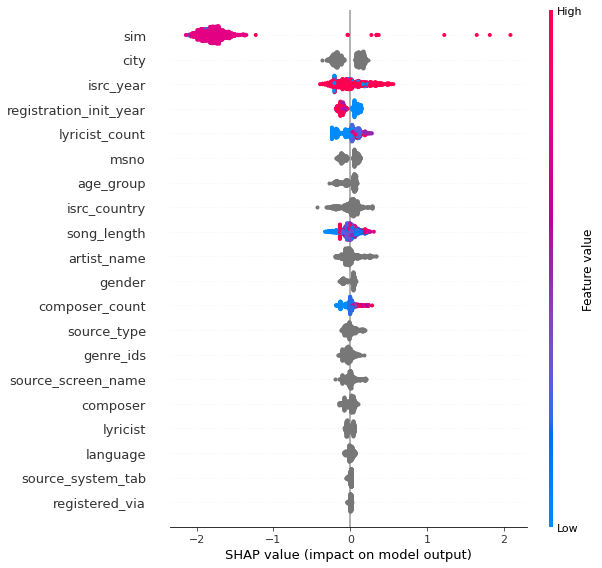

In [16]:
shap_class.show_shap_values()